In [1]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
import pandas as pd
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR


c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dades = read_csv('dadesSauMulti.csv', sep=';',header=0, index_col=0)

vol = dades['Volum']
tm = dades['TM']
hrm = dades['HRM']
ppt = dades['PPT']
pm = dades['PM']

# convert to [rows, columns] structure
vol = vol.reshape((len(vol), 1))
tm = tm.reshape((len(tm), 1))
hrm = hrm.reshape((len(hrm), 1))
ppt = ppt.reshape((len(ppt), 1))
pm = pm.reshape((len(pm), 1))


# horizontally stack columns
dataset = hstack((vol,tm,hrm,ppt,pm,vol))

scaler = MinMaxScaler(feature_range=(0, 1))
datasetN = scaler.fit_transform(dataset)

c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  de

In [3]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [4]:
def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

In [5]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [6]:
n_steps_in = 20
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)

In [7]:
# flatten input
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))

In [8]:
from scipy.stats import uniform
from scipy.stats import randint
c=[]
epsilon=[]
gamma=[]

for i in range(500):
    c.append((randint.rvs(5, 125)))
    epsilon.append(round(uniform.rvs(0.0001, 0.1),4))
    gamma.append(round(uniform.rvs(0.01, 0.9),4))
    



In [11]:
#Simulació RandomizedSearchCV per SVM
resultat=[]

for c_v, eps, gam in zip(c, epsilon, gamma):
    regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=c_v, gamma=gam, epsilon=eps))
    regr_multisvr.fit(train_X, train_Y)
    # Predict on new data
    yhat = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT,c_v,gam,eps)
    resultat.append((c_v, gam, eps, RMSE_days,RMSE_TOT))
                 
    

7.054115131306818 69 0.487 0.0685
7.152058659360857 15 0.1129 0.0447
6.638623598492236 106 0.5146 0.0297
7.072924355918611 108 0.4108 0.0759
7.385011706768727 45 0.1043 0.0945
8.199112863184661 110 0.76 0.0903
6.651560341600878 118 0.3799 0.0315
6.6467731387353055 122 0.4274 0.0386
7.323615822717814 28 0.5843 0.0726
7.794953825277538 90 0.1188 0.0147
6.709792648831092 15 0.5326 0.0376
6.688472011297613 60 0.4482 0.0441
6.9666872408081515 53 0.7598 0.0023
7.132189437994405 19 0.261 0.0825
7.153804578102091 97 0.1624 0.0422
6.908250453621875 102 0.2449 0.0481
6.634982986074934 46 0.4336 0.0361
6.940444723969489 102 0.2321 0.0446
7.313305935402147 29 0.4154 0.0902
7.978993071381762 123 0.6383 0.0996
7.001264895659866 19 0.3366 0.0103
7.726768212431409 116 0.0621 0.0152
6.888128936945594 66 0.2584 0.0527
6.793288494415269 59 0.3123 0.0505
6.940543340855994 14 0.0209 0.0969
7.460693343273714 33 0.058 0.0937
7.616310244071022 78 0.6045 0.0841
7.23071337271655 45 0.3379 0.0909
7.2150639114895

7.664471437564731 33 0.8515 0.0499
7.422923774489331 13 0.4386 0.0959
6.759601018346356 63 0.635 0.022
6.650604102341645 21 0.4409 0.0391
8.578040337640042 8 0.8448 0.094
7.05111047630033 40 0.3734 0.0767
6.636681876335256 88 0.4533 0.0219
8.029542927943153 118 0.1131 0.0098
7.110974607700126 102 0.3763 0.0802
7.245064581127292 38 0.6527 0.0585
7.4483158315031694 6 0.474 0.0921
5.49094523039914 29 0.0154 0.0201
7.503075522532711 65 0.8429 0.043
6.908418753033663 83 0.4575 0.0616
6.91474563805275 116 0.7094 0.0247
7.173015144246884 50 0.487 0.0752
7.46381893043606 98 0.0466 0.0786
7.155867462926614 64 0.173 0.0359
7.626393224264079 84 0.7774 0.0595
6.967425435100815 124 0.3852 0.006
7.563397052006367 119 0.7449 0.0615
7.282993888116985 54 0.1018 0.0521
7.370045001002347 71 0.0662 0.0291
6.805422703246762 85 0.3175 0.0533
7.669143707333312 117 0.8126 0.0561
7.855768430044013 119 0.8641 0.0568
7.481260096753518 41 0.7748 0.0528
7.07797790810887 71 0.2227 0.072
6.7545856340605335 90 0.3256

7.1818269286459175 111 0.0346 0.0561
6.7887617113354395 57 0.3302 0.0528
6.806099387822006 47 0.6699 0.0105
8.273356871841886 50 0.8941 0.0718
7.070592588510199 36 0.3047 0.0791
7.1782642178042915 9 0.2655 0.0869
7.320448887135417 85 0.3461 0.0999
7.985861085271287 72 0.1375 0.0077
6.964167653564732 9 0.7319 0.0243
6.733819341516189 58 0.6204 0.0196
7.535820296687651 19 0.8506 0.0435
7.004294304045731 24 0.5786 0.0546
7.6344536043171205 96 0.7144 0.0706
7.051611046640976 92 0.2004 0.0386
7.424355281828307 21 0.8226 0.0421
8.29918152994711 91 0.0806 0.0045
6.8371028211876625 23 0.2884 0.0294
7.189775935804292 6 0.311 0.006
6.980199185641745 5 0.2128 0.0333
6.796548021495817 61 0.4799 0.0518
7.375043612400518 89 0.5591 0.0779
8.171318609775133 113 0.081 0.0092
7.16972890788731 89 0.1996 0.0779
6.729814854732672 78 0.5022 0.0096
7.1425432929829515 46 0.0207 0.0938
7.573513296093777 21 0.7458 0.0619
6.654182189242467 73 0.4846 0.0364
7.677532181093725 90 0.1846 0.0087
7.0596697100681745 17

In [18]:
varlist = []
for i in range(len(c)):
    varlist.append(resultat[i])
    
resultFinal = pd.DataFrame(varlist)
resultFinal.columns=['C','gamma',  'epsilon','RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,C,gamma,epsilon,RMSE_dies,RMSE_total
0,29,0.0154,0.0201,"[1.590792598482574, 2.2205282836391227, 2.8053...",5.490945
1,21,0.0289,0.0306,"[2.315949057366181, 2.7259605644106095, 3.3535...",5.851852
2,42,0.0228,0.0349,"[2.5194931451280196, 2.880587380420443, 3.5232...",5.957533
3,16,0.0427,0.0068,"[1.1937274562562585, 1.9774685284966445, 2.716...",5.977381
4,12,0.0411,0.0423,"[2.8836986679056915, 3.2779359828533527, 3.807...",6.175317
5,51,0.0133,0.0620,"[3.3843567232568463, 3.745467538035221, 4.4007...",6.238265
6,38,0.0444,0.0096,"[1.3487431885657162, 2.210569162854288, 3.0003...",6.445186
7,15,0.0179,0.0803,"[4.012792930030678, 4.3945198405348735, 4.8197...",6.523924
8,11,0.0363,0.0661,"[3.5623560328813126, 3.938137633297717, 4.4741...",6.533326
9,41,0.4527,0.0335,"[3.862052431873085, 4.0854308247641065, 4.4479...",6.624883


In [23]:
# Simulació GridSearchCV random forest
import numpy as np
resultatsf = []
gamma = np.arange(0.01,0.021,0.001)
c = np.arange(25,35,1)
epsilon = np.arange(0.015,0.025,0.001)

for c_v in c:
    for eps in epsilon:
        resultat = []
        for gam in gamma:
            regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=c_v, gamma=gam, epsilon=eps))
            regr_multisvr.fit(train_X, train_Y)
            # Predict on new data
            yhat = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
            # invertim prediccions per tenir-les en l'escala original
            yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
            test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
            #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
            dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
            inv_yhat = scaler.inverse_transform(dataset2)
            testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
            #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
            test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
            RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
            print(RMSE_TOT,c_v,gam,eps)
            resultat.append((c_v, gam, eps, RMSE_days,RMSE_TOT))
        
        resultatsf.append(resultat)


5.373814549039866 25 0.01 0.015
5.3876680874937195 25 0.011 0.015
5.400906250584343 25 0.011999999999999999 0.015
5.417327648149059 25 0.012999999999999998 0.015
5.434705126108 25 0.013999999999999997 0.015
5.452381653841591 25 0.014999999999999996 0.015
5.468668086924007 25 0.015999999999999993 0.015
5.486477683815418 25 0.016999999999999994 0.015
5.505535769157827 25 0.017999999999999995 0.015
5.525461256936827 25 0.018999999999999993 0.015
5.545848074732165 25 0.01999999999999999 0.015
5.376809493171571 25 0.01 0.016
5.3895332745727345 25 0.011 0.016
5.403897610104423 25 0.011999999999999999 0.016
5.419654739960049 25 0.012999999999999998 0.016
5.43642787134626 25 0.013999999999999997 0.016
5.453830110150673 25 0.014999999999999996 0.016
5.470321397125968 25 0.015999999999999993 0.016
5.4879900004621325 25 0.016999999999999994 0.016
5.507021311901217 25 0.017999999999999995 0.016
5.528138499366056 25 0.018999999999999993 0.016
5.54835933507377 25 0.01999999999999999 0.016
5.38021350

5.55684097466274 26 0.01999999999999999 0.017
5.385012464632925 26 0.01 0.018000000000000002
5.397489281046484 26 0.011 0.018000000000000002
5.413366148772971 26 0.011999999999999999 0.018000000000000002
5.429175486608884 26 0.012999999999999998 0.018000000000000002
5.445838415534376 26 0.013999999999999997 0.018000000000000002
5.4633401476504195 26 0.014999999999999996 0.018000000000000002
5.480152842678748 26 0.015999999999999993 0.018000000000000002
5.498101566732437 26 0.016999999999999994 0.018000000000000002
5.517705350888273 26 0.017999999999999995 0.018000000000000002
5.538753603918811 26 0.018999999999999993 0.018000000000000002
5.558276727383293 26 0.01999999999999999 0.018000000000000002
5.389543483680974 26 0.01 0.019000000000000003
5.402190092671821 26 0.011 0.019000000000000003
5.4190467419223936 26 0.011999999999999999 0.019000000000000003
5.436425810305836 26 0.012999999999999998 0.019000000000000003
5.452391415723335 26 0.013999999999999997 0.019000000000000003
5.46925

5.427178808339787 27 0.011999999999999999 0.020000000000000004
5.444064251371479 27 0.012999999999999998 0.020000000000000004
5.461667288872243 27 0.013999999999999997 0.020000000000000004
5.477666197124758 27 0.014999999999999996 0.020000000000000004
5.494124780759694 27 0.015999999999999993 0.020000000000000004
5.511050931349812 27 0.016999999999999994 0.020000000000000004
5.528576320477784 27 0.017999999999999995 0.020000000000000004
5.547616387529682 27 0.018999999999999993 0.020000000000000004
5.568030693173991 27 0.01999999999999999 0.020000000000000004
5.398674249968533 27 0.01 0.021000000000000005
5.415442298921223 27 0.011 0.021000000000000005
5.432143488677457 27 0.011999999999999999 0.021000000000000005
5.448743948440764 27 0.012999999999999998 0.021000000000000005
5.46453389131072 27 0.013999999999999997 0.021000000000000005
5.480348132495362 27 0.014999999999999996 0.021000000000000005
5.497365180873885 27 0.015999999999999993 0.021000000000000005
5.514733632045074 27 0.01

5.468713146636857 28 0.013999999999999997 0.022000000000000006
5.486076197560739 28 0.014999999999999996 0.022000000000000006
5.504857864857681 28 0.015999999999999993 0.022000000000000006
5.523438021659293 28 0.016999999999999994 0.022000000000000006
5.542503925902902 28 0.017999999999999995 0.022000000000000006
5.562628302084224 28 0.018999999999999993 0.022000000000000006
5.583279769852848 28 0.01999999999999999 0.022000000000000006
5.405649209662197 28 0.01 0.023000000000000007
5.42030075595299 28 0.011 0.023000000000000007
5.437004291341238 28 0.011999999999999999 0.023000000000000007
5.454553462135716 28 0.012999999999999998 0.023000000000000007
5.472129414099468 28 0.013999999999999997 0.023000000000000007
5.489912988209905 28 0.014999999999999996 0.023000000000000007
5.508265649738687 28 0.015999999999999993 0.023000000000000007
5.52762051944391 28 0.016999999999999994 0.023000000000000007
5.547245851295009 28 0.017999999999999995 0.023000000000000007
5.568250339393226 28 0.018

5.516403701270302 29 0.015999999999999993 0.024000000000000007
5.53514398351138 29 0.016999999999999994 0.024000000000000007
5.557186706555535 29 0.017999999999999995 0.024000000000000007
5.580462851783144 29 0.018999999999999993 0.024000000000000007
5.605581076403237 29 0.01999999999999999 0.024000000000000007
5.413340191777062 29 0.01 0.02500000000000001
5.429422259544701 29 0.011 0.02500000000000001
5.447176724854809 29 0.011999999999999999 0.02500000000000001
5.465276712004971 29 0.012999999999999998 0.02500000000000001
5.483729082543529 29 0.013999999999999997 0.02500000000000001
5.50292022726918 29 0.014999999999999996 0.02500000000000001
5.520885246725532 29 0.015999999999999993 0.02500000000000001
5.540463192170873 29 0.016999999999999994 0.02500000000000001
5.564028842539294 29 0.017999999999999995 0.02500000000000001
5.589542375762647 29 0.018999999999999993 0.02500000000000001
5.615960821000356 29 0.01999999999999999 0.02500000000000001
5.380309725796804 30 0.01 0.015
5.3944

5.383341249426823 31 0.01 0.016
5.398493784796567 31 0.011 0.016
5.416242594212478 31 0.011999999999999999 0.016
5.434997227651378 31 0.012999999999999998 0.016
5.453629587529734 31 0.013999999999999997 0.016
5.47282738150764 31 0.014999999999999996 0.016
5.49317962965072 31 0.015999999999999993 0.016
5.5151347134763355 31 0.016999999999999994 0.016
5.5379086027759135 31 0.017999999999999995 0.016
5.55804415014906 31 0.018999999999999993 0.016
5.579429900697476 31 0.01999999999999999 0.016
5.386228884377891 31 0.01 0.017
5.401860154882996 31 0.011 0.017
5.419495882321582 31 0.011999999999999999 0.017
5.438227476758497 31 0.012999999999999998 0.017
5.455902081563148 31 0.013999999999999997 0.017
5.474501084466089 31 0.014999999999999996 0.017
5.49599705420703 31 0.015999999999999993 0.017
5.517868212669496 31 0.016999999999999994 0.017
5.54138157059432 31 0.017999999999999995 0.017
5.562067210611345 31 0.018999999999999993 0.017
5.581807559475534 31 0.01999999999999999 0.017
5.390675182

5.547450643879682 32 0.017999999999999995 0.018000000000000002
5.566843167135231 32 0.018999999999999993 0.018000000000000002
5.5874495697867195 32 0.01999999999999999 0.018000000000000002
5.396584534927399 32 0.01 0.019000000000000003
5.414730709754138 32 0.011 0.019000000000000003
5.433078674624794 32 0.011999999999999999 0.019000000000000003
5.4499755409491915 32 0.012999999999999998 0.019000000000000003
5.468620328266458 32 0.013999999999999997 0.019000000000000003
5.4873748895863566 32 0.014999999999999996 0.019000000000000003
5.506486250192529 32 0.015999999999999993 0.019000000000000003
5.526661916036927 32 0.016999999999999994 0.019000000000000003
5.547787585442615 32 0.017999999999999995 0.019000000000000003
5.568089473502679 32 0.018999999999999993 0.019000000000000003
5.590597086926159 32 0.01999999999999999 0.019000000000000003
5.400832758088568 32 0.01 0.020000000000000004
5.420351286964215 32 0.011 0.020000000000000004
5.438041923083781 32 0.011999999999999999 0.020000000

5.599664789693608 33 0.01999999999999999 0.020000000000000004
5.408991586585966 33 0.01 0.021000000000000005
5.427079343874 33 0.011 0.021000000000000005
5.444672700322796 33 0.011999999999999999 0.021000000000000005
5.4620413255416445 33 0.012999999999999998 0.021000000000000005
5.480219095684593 33 0.013999999999999997 0.021000000000000005
5.499004844816636 33 0.014999999999999996 0.021000000000000005
5.5171834084675 33 0.015999999999999993 0.021000000000000005
5.537959818580011 33 0.016999999999999994 0.021000000000000005
5.5591001608626875 33 0.017999999999999995 0.021000000000000005
5.581139245382432 33 0.018999999999999993 0.021000000000000005
5.604840060788753 33 0.01999999999999999 0.021000000000000005
5.411065694538819 33 0.01 0.022000000000000006
5.428633829012663 33 0.011 0.022000000000000006
5.446690176342241 33 0.011999999999999999 0.022000000000000006
5.463992368054652 33 0.012999999999999998 0.022000000000000006
5.4822900018470895 33 0.013999999999999997 0.02200000000000

5.43250352933875 34 0.011 0.023000000000000007
5.450183943987448 34 0.011999999999999999 0.023000000000000007
5.468708234048451 34 0.012999999999999998 0.023000000000000007
5.4892889512995025 34 0.013999999999999997 0.023000000000000007
5.509326343351184 34 0.014999999999999996 0.023000000000000007
5.529573700642128 34 0.015999999999999993 0.023000000000000007
5.551442759492763 34 0.016999999999999994 0.023000000000000007
5.5741815702048 34 0.017999999999999995 0.023000000000000007
5.599147571671587 34 0.018999999999999993 0.023000000000000007
5.627814564199296 34 0.01999999999999999 0.023000000000000007
5.416135236906359 34 0.01 0.024000000000000007
5.43479681036783 34 0.011 0.024000000000000007
5.453809608580363 34 0.011999999999999999 0.024000000000000007
5.474096709178519 34 0.012999999999999998 0.024000000000000007
5.492635003776277 34 0.013999999999999997 0.024000000000000007
5.512971565232994 34 0.014999999999999996 0.024000000000000007
5.533252467471462 34 0.015999999999999993 

In [25]:
resultatsEpDe = pd.DataFrame(resultatsf)
varlist = []
for i in range(len(c)):
    resultatsEpDe = pd.DataFrame(resultatsf[i])
    varlist.append(resultatsEpDe)
    
resultFinal = pd.concat(varlist)
resultFinal.columns=['C', 'gamma', 'epsilon', 'RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,C,gamma,epsilon,RMSE_dies,RMSE_total
0,25,0.010,0.015,"[1.3347196232042113, 1.975139838649984, 2.5963...",5.373815
1,25,0.010,0.016,"[1.378071581962384, 2.0088293412392866, 2.6177...",5.376809
2,25,0.010,0.017,"[1.4274321730647348, 2.0379584565840307, 2.633...",5.380214
3,25,0.010,0.018,"[1.4764810025038266, 2.062521480095045, 2.6532...",5.384032
4,25,0.011,0.015,"[1.3416366839128595, 1.9884878906397707, 2.603...",5.387668
5,25,0.010,0.019,"[1.5276319393816609, 2.091687647082653, 2.6790...",5.388099
6,25,0.011,0.016,"[1.3826845004743513, 2.0156537867396915, 2.626...",5.389533
7,25,0.011,0.017,"[1.4248427938376205, 2.042534988300059, 2.6444...",5.392568
8,25,0.010,0.020,"[1.583708575162401, 2.1231309613701943, 2.7082...",5.393129
9,25,0.010,0.021,"[1.637746809788658, 2.1539102504331953, 2.7270...",5.395994


In [26]:
regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=25, gamma=0.01, epsilon=0.015))
regr_multisvr.fit(train_X, train_Y)
# Predict on new data
yhat = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)

In [28]:
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],3))


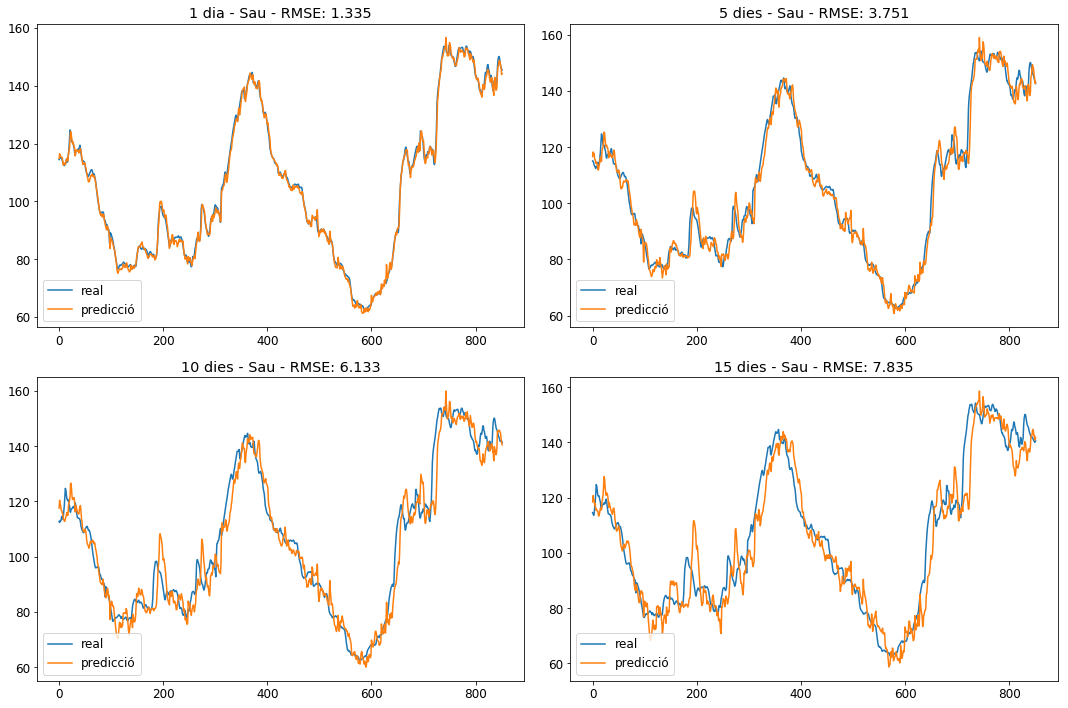

In [29]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=3)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=3)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=3)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=3)


fig.tight_layout()
plt.show()

In [30]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

╒═════════╤═════════╤═════════╤═════════╤═════════╕
│   dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞═════════╪═════════╪═════════╪═════════╪═════════╡
│ 1.33472 │ 1.97514 │ 2.59636 │ 3.15956 │ 3.75103 │
╘═════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 4.29659 │   4.782 │  5.2714 │ 5.70489 │  6.13329 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│  6.52046 │  6.83473 │  7.14031 │  7.47062 │  7.83508 │ 5.37381 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


In [7]:
n_steps_out = 15
propTrainTest = 0.8


In [14]:
import numpy as np
n_steps_in = np.arange(5,101,2)
resultat = []
for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, datasetN)
    n_input = train_X.shape[1] * train_X.shape[2]
    train_X = train_X.reshape((train_X.shape[0], n_input))
    test_X = test_X.reshape((test_X.shape[0], n_input))
    regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=25, gamma=0.01, epsilon=0.015))
    regr_multisvr.fit(train_X, train_Y)
    # Predict on new data
    yhat = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

5.315868707038672 5
5.304767089901805 7
5.298803205302298 9
5.2960802260151585 11
5.308626184488807 13
5.3131522877258215 15
5.328782395129681 17
5.356121854982727 19
5.376863443871402 21
5.373854161160858 23
5.399994616140476 25
5.416456085434767 27
5.459647905395708 29
5.542622229624472 31
5.613608660798605 33
5.714577690919446 35
5.83450838709314 37
5.943732524685137 39
6.0092914868173155 41
6.137678021199209 43
6.318535292959695 45
6.475176144190297 47
6.58185788751441 49
6.649173690394142 51
6.7292140268596485 53
6.772610293110485 55
6.814032863529954 57
6.821649368801089 59
6.818154483017447 61
6.832851903702758 63
6.878309339937123 65
6.954761988601061 67
7.056184366464983 69
7.153503350224855 71
7.226486254845215 73
7.315693756118809 75
7.415624202004731 77
7.559159782157525 79
7.696835312419688 81
7.832088371883545 83
7.908303146187295 85
7.990941066815209 87
8.06056647991578 89
8.141824467642104 91
8.218443390422044 93
8.198687192923758 95
8.177734622911625 97
8.1789432823894

In [15]:
import numpy as np
n_steps_in = np.arange(8,13,1)
resultat = []
for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, datasetN)
    n_input = train_X.shape[1] * train_X.shape[2]
    train_X = train_X.reshape((train_X.shape[0], n_input))
    test_X = test_X.reshape((test_X.shape[0], n_input))
    regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=25, gamma=0.01, epsilon=0.015))
    regr_multisvr.fit(train_X, train_Y)
    # Predict on new data
    yhat = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

5.300779491549558 8
5.298803205302298 9
5.298188048213393 10
5.2960802260151585 11
5.299868150695014 12


In [20]:
resultFinal = pd.DataFrame(resultat)
    
resultFinal.columns=['time steps in', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

display(resultFinal)

,time steps in,RMSE_total
0,11,5.296080
1,10,5.298188
2,9,5.298803
3,12,5.299868
4,8,5.300779


In [8]:
n_steps_out = 15
propTrainTest = 0.8
n_steps_in = 11

train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))
regr_multisvr = MultiOutputRegressor(SVR(kernel='rbf', C=25, gamma=0.01, epsilon=0.015))
regr_multisvr.fit(train_X, train_Y)
# Predict on new data
yhat = regr_multisvr.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

5.2960802260151585


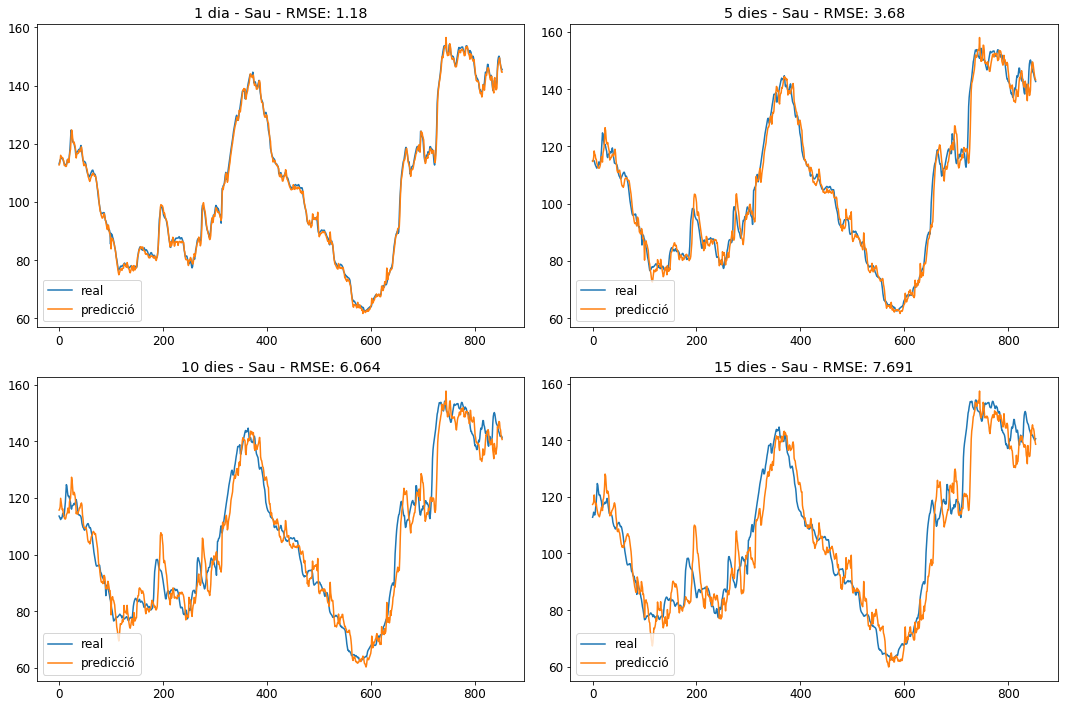

In [9]:
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],3))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=3)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=3)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=3)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=3)


fig.tight_layout()
plt.show()

In [10]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

╒═════════╤═════════╤═════════╤═════════╤═════════╕
│   dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞═════════╪═════════╪═════════╪═════════╪═════════╡
│ 1.17992 │ 1.87451 │ 2.49735 │ 3.10404 │ 3.67981 │
╘═════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 4.20818 │ 4.68955 │ 5.17535 │ 5.63136 │  6.06364 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│  6.44124 │  6.77431 │  7.08254 │  7.39951 │  7.69072 │ 5.29608 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


Aquest es el resultat definitiu després de buscar el nombre d'entrades ideal.

In [12]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts_rquad(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        r_quad = r2_score(actual[:, i], predicted[:, i])
        mae = mean_absolute_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append((rmse,r_quad,mae,mse))
    # calcul global de RMSE
    s = 0
    r = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [13]:
RMSE_TOT, RMSE_days = evaluate_forecasts_rquad(test_YR,testPredict)
global_y = test_YR.reshape((test_YR.shape[0]*test_YR.shape[1], 1))
global_pred = testPredict.reshape((testPredict.shape[0]*testPredict.shape[1], 1))
r_quad = r2_score(global_y, global_pred)
rmse = sqrt(mean_squared_error(global_y, global_pred))
mse = mean_squared_error(global_y, global_pred)
mae = mean_absolute_error(global_y, global_pred)

res_globals=[rmse, r_quad, mae, mse]

resultsDF =  pd.DataFrame(RMSE_days)
resultsDF = resultsDF.T
resultsDF['Global'] = res_globals
resultsDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
resultsDF.rename(index={0:'RMSE',1:'R2',2:'MAE', 3:'MSE'}, inplace=True)
resultsDF = resultsDF.round(4)
display(resultsDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,1.1799,1.8745,2.4974,3.1040,3.6798,4.2082,4.6896,5.1754,5.6314,6.0636,6.4412,6.7743,7.0825,7.3995,7.6907,5.2961
R2,0.9979,0.9947,0.9906,0.9855,0.9797,0.9734,0.9671,0.9600,0.9528,0.9453,0.9385,0.9321,0.9259,0.9193,0.9130,0.9581
MAE,0.9175,1.4004,1.8297,2.2379,2.6490,3.0336,3.4036,3.7933,4.1471,4.4849,4.7630,4.9934,5.2433,5.4967,5.7391,3.6088
MSE,1.3922,3.5138,6.2368,9.6351,13.5410,17.7087,21.9919,26.7843,31.7123,36.7678,41.4896,45.8913,50.1624,54.7528,59.1472,28.0485


In [15]:
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
v = RMSE_days
ultim = v.append(RMSE_TOT)

dades_diesDF=pd.DataFrame(v)
dades_diesDF=dades_diesDF.round(3)
dades_diesDF=dades_diesDF.T
dades_diesDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
dades_diesDF.rename(index={0:'RMSE'}, inplace=True)

display(dades_diesDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,1.18,1.875,2.497,3.104,3.68,4.208,4.69,5.175,5.631,6.064,6.441,6.774,7.083,7.4,7.691,5.296


In [16]:
resultsDF.to_csv('svm-multi-sau.csv', sep=',', encoding='utf-8')